## Build an Author Co-authorship Network (undirected, weighted)

In [9]:
import os
import json
import itertools
import networkx as nx

FOLDER = "../papers_full"

# Undirected co-authorship network
G_auth = nx.Graph()

# Author metadata: id -> {name, institutions (set), n_papers}
author_meta = {}

print("Building author co-authorship graph...")

for filename in os.listdir(FOLDER):
    if not filename.endswith(".json"):
        continue

    with open(os.path.join(FOLDER, filename), "r", encoding="utf-8") as f:
        data = json.load(f)

    authors_this_paper = []

    for a in data.get("authors", []):
        aid = a.get("id")
        if not aid:
            continue

        name = a.get("name") or ""
        insts = [inst for inst in a.get("affiliations", []) if inst]

        meta = author_meta.setdefault(
            aid,
            {"name": name, "institutions": set(), "n_papers": 0}
        )
        # Keep latest non-empty name
        if name:
            meta["name"] = name
        meta["institutions"].update(insts)
        meta["n_papers"] += 1

        authors_this_paper.append(aid)

    # Skip single-author papers
    if len(authors_this_paper) < 2:
        continue

    # Add nodes
    for aid in authors_this_paper:
        G_auth.add_node(aid)

    # Add / increment undirected edges between co-authors
    for a1, a2 in itertools.combinations(authors_this_paper, 2):
        if G_auth.has_edge(a1, a2):
            G_auth[a1][a2]["weight"] += 1
        else:
            G_auth.add_edge(a1, a2, weight=1)

# Attach node attributes
for aid, meta in author_meta.items():
    if aid in G_auth:
        G_auth.nodes[aid]["name"] = meta["name"]
        G_auth.nodes[aid]["institutions"] = ", ".join(sorted(meta["institutions"]))
        G_auth.nodes[aid]["n_papers"] = meta["n_papers"]

print("Author co-authorship graph built.")
print(f"Nodes (authors): {G_auth.number_of_nodes()}")
print(f"Edges (co-authorship relations): {G_auth.number_of_edges()}")

# Keep the giant connected component for analysis
if not nx.is_connected(G_auth):
    gcc_nodes = max(nx.connected_components(G_auth), key=len)
    G_auth_gcc = G_auth.subgraph(gcc_nodes).copy()
else:
    G_auth_gcc = G_auth

print(f"GCC size: {G_auth_gcc.number_of_nodes()} nodes, {G_auth_gcc.number_of_edges()} edges")

nx.write_gexf(G_auth_gcc, "author_coauthorship_gcc.gexf")

Building author co-authorship graph...
Author co-authorship graph built.
Nodes (authors): 65931
Edges (co-authorship relations): 285288
GCC size: 24860 nodes, 157652 edges


## Degree Distribution + Random Graph Comparison (Erdős–Rényi)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

G = G_auth_gcc  # shorthand

degrees = np.array([d for _, d in G.degree()])
print(f"Average degree: {degrees.mean():.2f}")
print(f"Max degree: {degrees.max()}")

Average degree: 12.68
Max degree: 179


Now compare to an Erdős–Rényi graph with same N and M and compare clustering + degree shape.

N=24860, M=157652, p=0.000510
Average clustering (real co-authorship network): 0.8776
Average clustering (Erdős–Rényi): 0.0005


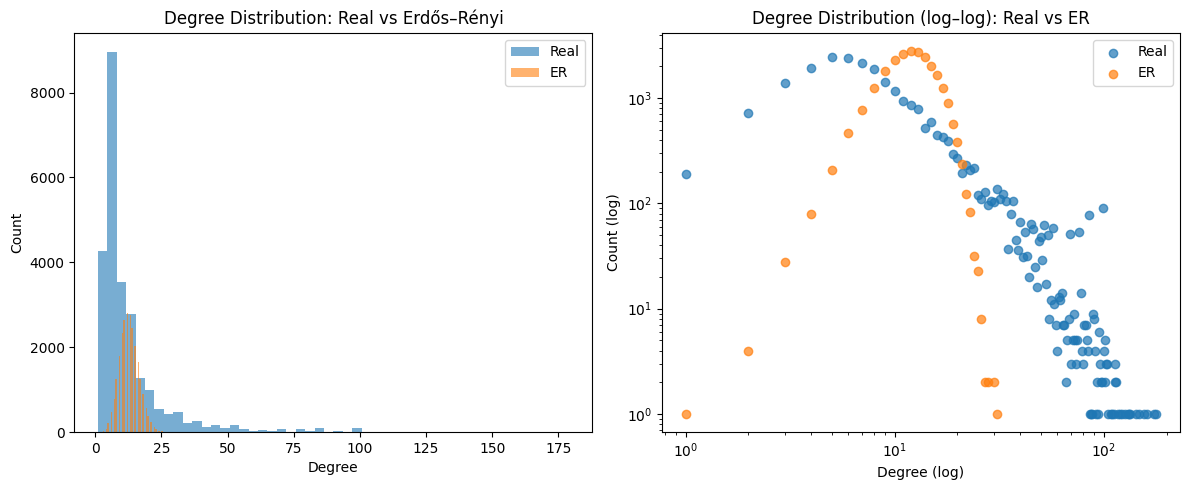

In [11]:
from networkx.algorithms.cluster import average_clustering

N = G.number_of_nodes()
M = G.number_of_edges()
p = 2 * M / (N * (N - 1))

print(f"N={N}, M={M}, p={p:.6f}")

C_real = average_clustering(G)
print(f"Average clustering (real co-authorship network): {C_real:.4f}")

# Build ER graph with same N and p
G_er = nx.gnp_random_graph(N, p)
C_er = average_clustering(G_er)
print(f"Average clustering (Erdős–Rényi): {C_er:.4f}")

# Degree distribution of ER for comparison
deg_er = np.array([d for _, d in G_er.degree()])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(degrees, bins=50, alpha=0.6, label="Real")
plt.hist(deg_er, bins=50, alpha=0.6, label="ER")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution: Real vs Erdős–Rényi")
plt.legend()

plt.subplot(1, 2, 2)
u_real, c_real = np.unique(degrees, return_counts=True)
u_er, c_er = np.unique(deg_er, return_counts=True)
plt.scatter(u_real, c_real, alpha=0.7, label="Real")
plt.scatter(u_er, c_er, alpha=0.7, label="ER")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (log)")
plt.ylabel("Count (log)")
plt.title("Degree Distribution (log–log): Real vs ER")
plt.legend()

plt.tight_layout()
plt.show()


### Friendship Paradox for Authors

In [12]:
from statistics import mean

deg = dict(G.degree())
avg_k = mean(deg.values())

# Average neighbor degree for each node
knn = nx.average_neighbor_degree(G)

avg_knn = mean(knn[n] for n in G.nodes())
print(f"Average author degree E[k]: {avg_k:.2f}")
print(f"Average neighbor degree E[k_neighbor]: {avg_knn:.2f}")

# Fraction of authors for whom neighbors have higher degree
count_paradox = sum(
    1 for n in G.nodes()
    if deg[n] < knn[n]
)
frac_paradox = count_paradox / G.number_of_nodes()
print(f"Fraction of authors for whom k_neighbor > k: {frac_paradox:.3f}")

Average author degree E[k]: 12.68
Average neighbor degree E[k_neighbor]: 17.63
Fraction of authors for whom k_neighbor > k: 0.825


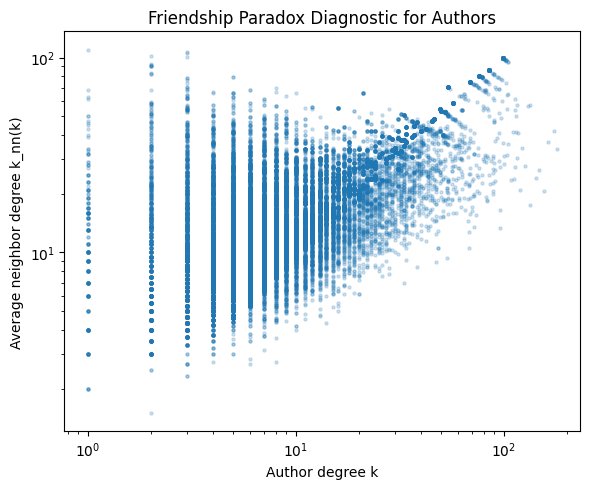

In [13]:
plt.figure(figsize=(6, 5))
plt.scatter(deg.values(), [knn[n] for n in G.nodes()], alpha=0.2, s=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Author degree k")
plt.ylabel("Average neighbor degree k_nn(k)")
plt.title("Friendship Paradox Diagnostic for Authors")
plt.tight_layout()
plt.show()

## Degree Assortativity (Authors)

Degree assortativity (authors co-authorship): r = 0.654
Pearson corr(k, avg neighbor k): r = 0.709, p = 0


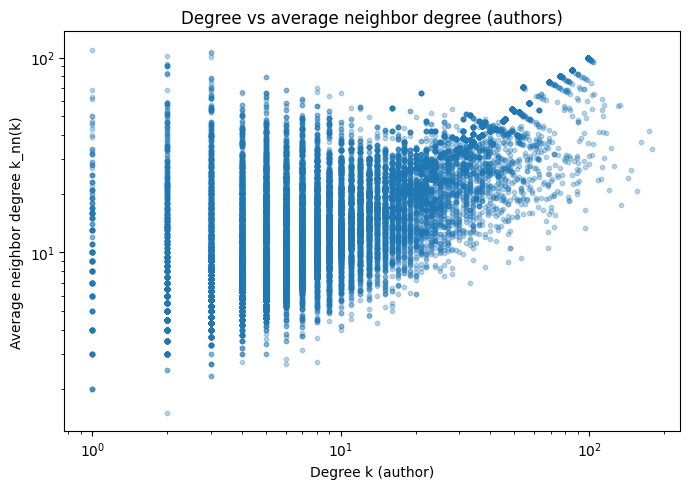

In [14]:
import numpy as np
from scipy.stats import pearsonr

r = nx.degree_assortativity_coefficient(G)
print(f"Degree assortativity (authors co-authorship): r = {r:.3f}")

deg_dict = dict(G.degree())
knn_deg = nx.average_neighbor_degree(G)

x = np.array([deg_dict[n] for n in G.nodes()])
y = np.array([knn_deg[n] for n in G.nodes()])

corr, p = pearsonr(x, y)
print(f"Pearson corr(k, avg neighbor k): r = {corr:.3f}, p = {p:.4g}")

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.3, s=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k (author)")
plt.ylabel("Average neighbor degree k_nn(k)")
plt.title("Degree vs average neighbor degree (authors)")
plt.tight_layout()
plt.show()

## Louvain Communities on Co-authorship + Export for Gephi

In [15]:
import community as community_louvain
from networkx.algorithms.community.quality import modularity as nx_modularity

print("Running Louvain on author co-authorship network...")

partition = community_louvain.best_partition(G, weight="weight", resolution=1.0)

# Attach community id to nodes
nx.set_node_attributes(G, partition, "community")

# Turn partition into community list for modularity
communities = {}
for n, cid in partition.items():
    communities.setdefault(cid, []).append(n)

Q = nx_modularity(G, list(communities.values()), weight="weight")
print(f"Louvain modularity (authors co-auth): Q = {Q:.4f}")
print(f"Number of author communities: {len(communities)}")

# Save for ForceAtlas2 visualisation
nx.write_gexf(G, "author_coauthorship_louvain.gexf")


Running Louvain on author co-authorship network...
Louvain modularity (authors co-auth): Q = 0.9380
Number of author communities: 129


## Eigenvector Centrality for Authors

In [16]:
eigen_auth = nx.eigenvector_centrality(G, max_iter=1000, weight="weight")

nx.set_node_attributes(G, eigen_auth, "eigencent")

# Top 20 authors by eigenvector centrality
top_eigen = sorted(eigen_auth.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 authors by eigenvector centrality:")
for aid, score in top_eigen:
    name = G.nodes[aid].get("name", "")
    inst = G.nodes[aid].get("institutions", "")
    npapers = G.nodes[aid].get("n_papers", 0)
    print(f"{aid} | {name} | {inst} | papers={npapers} | eigencent={score:.4f}")


Top 20 authors by eigenvector centrality:
https://openalex.org/A1945837108 | Eyal Klang | Icahn School of Medicine at Mount Sinai, Mount Sinai Health System, Mount Sinai Medical Center, Sheba Medical Center, Tel Aviv University | papers=72 | eigencent=0.5169
https://openalex.org/A2170298636 | GIRISH N. NADKARNI | Hasso Plattner Institute, Icahn School of Medicine at Mount Sinai, Mount Sinai Health System, Mount Sinai Medical Center | papers=52 | eigencent=0.4255
https://openalex.org/A1498187152 | Benjamin S Glicksberg | Icahn School of Medicine at Mount Sinai | papers=46 | eigencent=0.3919
https://openalex.org/A2513274694 | Shelly Soffer | Assuta Medical Center, Ben-Gurion University of the Negev, Rabin Medical Center, Tel Aviv University | papers=21 | eigencent=0.2389
https://openalex.org/A1968102139 | Robert Freeman | Icahn School of Medicine at Mount Sinai, Mount Sinai Health System | papers=19 | eigencent=0.2011
https://openalex.org/A2682811430 | Mahmud Omar | Icahn School of Medic

## Author Citation Network (with attributes)

In [17]:
import networkx as nx
import os
import json

FOLDER = "../papers_full"

G_ac = nx.DiGraph()

# Preload all paper data
papers = {
    fname[:-5]: json.load(open(os.path.join(FOLDER, fname), encoding="utf-8"))
    for fname in os.listdir(FOLDER)
    if fname.endswith(".json")
}

print(f"Loaded {len(papers)} papers for author citation network.")

for paper_id, data in papers.items():
    authors = [a.get("id") for a in data.get("authors", []) if a.get("id")]

    # Skip papers without authors
    if not authors:
        continue

    for ref_url in data.get("references", []):
        ref_id = ref_url.split("/")[-1]
        ref_paper = papers.get(ref_id)
        if not ref_paper:
            continue

        ref_authors = [a.get("id") for a in ref_paper.get("authors", []) if a.get("id")]

        for a in authors:
            for b in ref_authors:
                if a and b:
                    if G_ac.has_edge(a, b):
                        G_ac[a][b]["weight"] += 1
                    else:
                        G_ac.add_edge(a, b, weight=1)

# Attach metadata from author_meta if available
for aid, meta in author_meta.items():
    if aid in G_ac:
        G_ac.nodes[aid]["name"] = meta["name"]
        G_ac.nodes[aid]["institutions"] = ", ".join(sorted(meta["institutions"]))
        G_ac.nodes[aid]["n_papers"] = meta["n_papers"]

print("Author citation network built.")
print(f"Nodes (authors): {G_ac.number_of_nodes()}")
print(f"Edges (citations between authors): {G_ac.number_of_edges()}")

nx.write_gexf(G_ac, "author_citation_network.gexf")


Loaded 17891 papers for author citation network.
Author citation network built.
Nodes (authors): 55431
Edges (citations between authors): 2206140


In [18]:
in_deg_auth = dict(G_ac.in_degree())
out_deg_auth = dict(G_ac.out_degree())

top_in_auth = sorted(in_deg_auth.items(), key=lambda x: x[1], reverse=True)[:20]
top_out_auth = sorted(out_deg_auth.items(), key=lambda x: x[1], reverse=True)[:20]

print("\nTop 20 most cited authors (in-degree):")
for aid, d in top_in_auth:
    print(aid, "|", G_ac.nodes[aid].get("name", ""), "| indegree =", d)

print("\nTop 20 most citing authors (out-degree):")
for aid, d in top_out_auth:
    print(aid, "|", G_ac.nodes[aid].get("name", ""), "| outdegree =", d)



Top 20 most cited authors (in-degree):
https://openalex.org/A5100657725 | Jason Lee | indegree = 6021
https://openalex.org/A5088551093 | Quoc V. Le | indegree = 5163
https://openalex.org/A2273124145 | Dehghani, Mostafa | indegree = 4984
https://openalex.org/A4227555713 | Uszkoreit, Jakob | indegree = 4811
https://openalex.org/A4281193570 | Weissenborn, Dirk | indegree = 4715
https://openalex.org/A4227412476 | Radford, Alec | indegree = 4713
https://openalex.org/A2748553518 | Dosovitskiy, Alexey | indegree = 4581
https://openalex.org/A4222167770 | Unterthiner, Thomas | indegree = 4581
https://openalex.org/A4225989450 | Beyer, Lucas | indegree = 4580
https://openalex.org/A2590063661 | Kolesnikov, Alexander | indegree = 4580
https://openalex.org/A4225989451 | Zhai, Xiaohua | indegree = 4580
https://openalex.org/A4281193566 | Minderer, Matthias | indegree = 4567
https://openalex.org/A2746808582 | Heigold, Georg | indegree = 4567
https://openalex.org/A4288500584 | Gelly, Sylvain | indegree

In [19]:
eigen_ac = nx.eigenvector_centrality(G_ac, max_iter=1000, weight="weight")

top_eigen_ac = sorted(eigen_ac.items(), key=lambda x: x[1], reverse=True)[:20]

print("\nTop 20 authors by eigenvector centrality in the citation network:")
for aid, score in top_eigen_ac:
    name = G_ac.nodes[aid].get("name", "")
    inst = G_ac.nodes[aid].get("institutions", "")
    npapers = G_ac.nodes[aid].get("n_papers", 0)
    print(f"{aid} | {name} | {inst} | papers={npapers} | eigencent={score:.4f}")



Top 20 authors by eigenvector centrality in the citation network:
https://openalex.org/A1981475371 | Marco Liserre | Aalborg University, Kiel University | papers=77 | eigencent=0.6209
https://openalex.org/A2064389746 | Giampaolo Buticchi | Aalborg University, Clinical Research Center Kiel, Fachhochschule Kiel, Kiel University, University of Nottingham Ningbo China | papers=48 | eigencent=0.5120
https://openalex.org/A2082956346 | Giovanni De Carne | Karlsruhe Institute of Technology, Kiel University | papers=34 | eigencent=0.4421
https://openalex.org/A2097481921 | Markus Andresen | Kiel University | papers=16 | eigencent=0.2189
https://openalex.org/A2138647987 | Levy Ferreira Costa | Kiel University | papers=9 | eigencent=0.1904
https://openalex.org/A4207183541 | Zhi-Xiang Zou | Kiel University | papers=6 | eigencent=0.1702
https://openalex.org/A327080418 | Frede Blaabjerg | Aalborg University, Engineering (Italy) | papers=14 | eigencent=0.0936
https://openalex.org/A5113786508 | Consta

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the graph with ForceAtlas2 coordinates from Gephi
G_fa = nx.read_gexf("author_coauthorship_louvain.gexf")

# Extract positions from Gephi (Gephi stores 'x' and 'y' on each node)
pos = {
    n: (float(data["x"]), float(data["y"]))
    for n, data in G_fa.nodes(data=True)
}

# Optionally get communities and degrees (if they were stored)
communities = nx.get_node_attributes(G_fa, "community")
degrees = dict(G_fa.degree())

# Colors by community (fall back to 0 if missing)
comm_ids = np.array([communities.get(n, 0) for n in G_fa.nodes()])
# Avoid needing sklearn here; simple normalization:
comm_min, comm_max = comm_ids.min(), comm_ids.max() if len(comm_ids) else (0, 1)
if comm_max > comm_min:
    comm_norm = (comm_ids - comm_min) / (comm_max - comm_min)
else:
    comm_norm = np.zeros_like(comm_ids, dtype=float)

# Node sizes by degree
node_sizes = [degrees[n] * 2 for n in G_fa.nodes()]  # adjust factor if needed

fig, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(
    G_fa,
    pos,
    node_size=node_sizes,
    node_color=comm_norm,
    cmap=plt.cm.plasma,
    alpha=0.85,
    ax=ax
)
nx.draw_networkx_edges(
    G_fa,
    pos,
    alpha=0.08,
    width=0.3,
    ax=ax
)

ax.set_axis_off()
ax.set_title("Author Co-authorship Network – ForceAtlas2 layout from Gephi", fontsize=14)

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Community (normalized id)")

plt.tight_layout()
plt.show()


KeyError: 'x'